# 2

In [1]:
import gymnasium as gym
import torch
from torch import nn
from tqdm import trange

In [2]:
env = gym.make("CartPole-v1")

In [7]:
env.close()

In [ ]:
observaation, info = env.reset()
for _ in trange(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break
# env.close()
    

In [36]:
env.close()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            # nn.Softmax()
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.stack(x)

In [4]:
model = Network()
optim = torch.optim.Adam(model.parameters(), 0.0001)
# model(torch.from_numpy(observation)).argmax().item()

In [5]:
env = gym.make("CartPole-v1", render_mode='human')
losses = []
history = []

In [6]:

for round in trange(100):
    observation, info = env.reset()
    for _ in range(100):
        # action = env.action_space.sample()
        predictions = model(torch.from_numpy(observation))
        action = predictions.argmax().item()
        cr1 = predictions[action]
        action = action
        observation, reward, terminated, truncated, info = env.step(action)
        # reward = observation[2]
        if terminated: reward = 0
        next_predictions = model(torch.from_numpy(observation))
        cr2 = next_predictions.max()
        pred_reward = (cr1 - 0.9*cr2)
        losses.append((pred_reward-reward)**2)
        history.append(losses[-1].item())
        if terminated:
            # print("Terminated")
            break
        if truncated:
            # print("Truncated")
            break
    if round % 10 == 0:
        batch_loss = sum(losses)
        batch_loss.backward()
        optim.step()
        optim.zero_grad()
        losses = []

100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


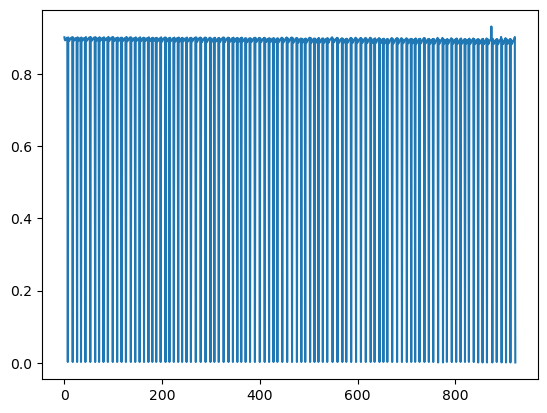

In [7]:
import matplotlib.pyplot as plt
plt.plot(history)

In [8]:
env.close()

# 1

In [1]:
import gymnasium as gym 

In [2]:
env = gym.make('CartPole-v1', render_mode='human')

In [ ]:
env.action_space

In [4]:
def action_policy(observation):
    return env.action_space.sample()

In [128]:
from tqdm import trange
def run_env(action_policy, rounds=100, after_action=lambda observation, reward: None):
    observation, info = env.reset()
    for i in trange(rounds):
        
        action = action_policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        after_action(observation, 0 if terminated else reward)
        # print(reward)
        if terminated:
            print("terminated")
            break
        if truncated:
            print("truncated")
            break

In [ ]:
run_env(action_policy)

In [38]:
env.close()

### Steps for model

network takes in observations and spits of cumulative rewards for each action.

action is argmax of netout

- observation
- predict cum reward cr1
- take action
- note actual reward r
- predict cum reward cr2
- loss from r vs cr1 - gam*cr2


In [7]:
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.stack = nn.Sequential(
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
    
    def forward(self, x) -> torch.Tensor:
        return self.stack(x)

In [ ]:
import torch.optim
model = Network()
optimizer = torch.optim.Adam(model.parameters())
ap = lambda observation: torch.argmax(model(torch.from_numpy(observation))).item()
run_env(ap)

In [132]:
observations = []
predictions = []
actions = []
reward_predictions = []
rewards = []

In [133]:
def ap2(observation):
    observation = torch.from_numpy(observation)
    observations.append(observation)
    preds: torch.Tensor = model(observation)
    predictions.append(preds)
    action = preds.argmax(0).item()
    actions.append(action)
    return action
def after_action(observation, reward):
    rewards.append(reward)

In [47]:
env = gym.make('CartPole-v1', render_mode='human')

In [ ]:
run_env(ap2, after_action=after_action)

In [ ]:
obs = torch.stack(observations)
preds = torch.stack(predictions)
acts = torch.tensor(actions)
rwds = torch.tensor(rewards)
obs.shape, preds.shape, acts.shape, rwds.shape

In [23]:
env.close()

In [ ]:
from tqdm import trange
def run_env(rounds=100, gamma=0.9):
    terminated = True
    losses = []
    lossfn = nn.MSELoss()
    rewards = []
    preds = []
    for _ in trange(rounds):
        if terminated:
            terminated = False
            observation, info = env.reset()
                
        cumilative_rewards = model(torch.from_numpy(observation))
        action = cumilative_rewards.argmax(0).item()
        cr1 = cumilative_rewards.max()
        # action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        cr2 = model(torch.from_numpy(observation)).max()
        reward_prediction = cr1 - gamma*cr2
        losses.append(
            lossfn(0 if terminated else reward, reward_prediction)
        )
        
        
        
        # print(reward)
        if terminated:
            print("terminated")
            break
        if truncated:
            print("truncated")
            break
run_env()

In [243]:
env.close()